# CNN Cancer Detection Kaggle Mini-Project

##  Brief Description of The Problem and Data 

This project is part of a Kaggle competition aimed at automatically detecting metastatic cancer in small image patches extracted from larger digital pathology scans. The goal is to develop a binary classifier that can predict whether a given image patch contains cancerous tissue.

## Data Overview

Dataset: The dataset consists of image patches of size 96x96 pixels. 
Training Set: Contains labeled images to train the model. 
Test Set: Contains unlabeled images for which predictions are needed. 
Class Distribution: The class labels indicate the presence (1) or absence (0) of cancer.


In [47]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import setuptools.dist
from PIL import Image
import tensorflow as tf
# Because I'm using jupyter notebook in vs code, I had to add "python" after tensorflow to get these libraries working
# https://stackoverflow.com/questions/71316443/google-colab-error-import-tensorflow-keras-models-could-not-be-resolvedrepor
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, InputLayer
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.engine import data_adapter
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator
from tensorflow.python.keras.regularizers import l2

In [35]:
train_images_path = ('./data/train/')
train_labels_data = pd.read_csv('./data/train_labels.csv')
print(train_labels_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None


In [36]:
print(train_labels_data.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## EDA(Exploratory Data Analysis)



In [37]:
train_labels_data.isnull().sum()

id       0
label    0
dtype: int64

As per the data description from Kaggle, this dataset was already cleaned therefore no duplicates and null.
Let's start with data visualization.

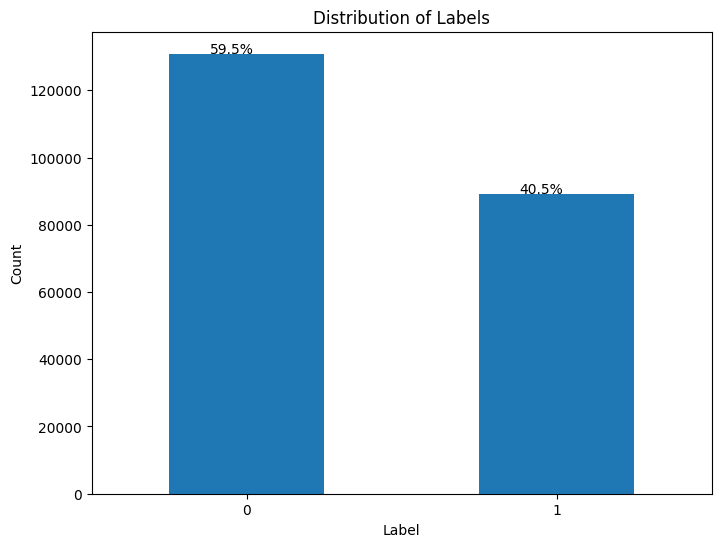

In [38]:
# Visualize class distribution and check for class imbalance

label_counts = train_labels_data['label'].value_counts()

plt.figure(figsize=(8, 6))
ax = label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

total = len(train_labels_data)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height() + total * 0.001
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

There is about 20% more non-cancer label than cancer label as per the chart above.

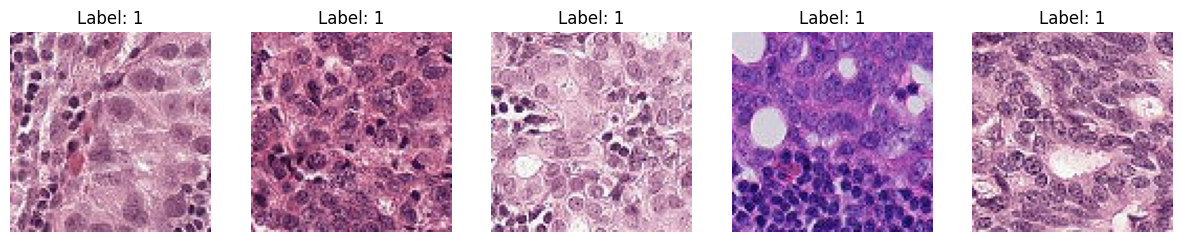

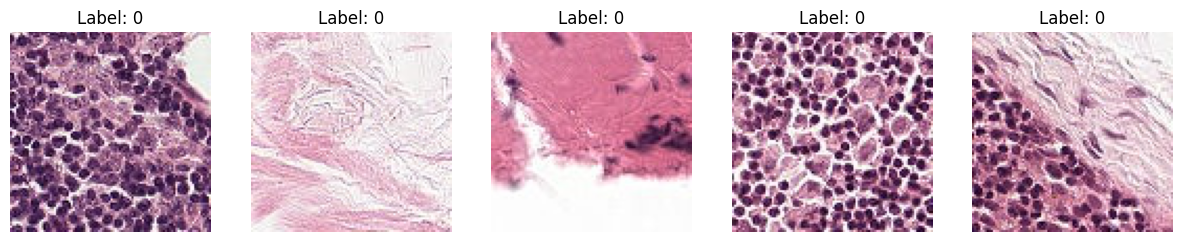

In [39]:
sample_cancer_ids = train_labels_data[train_labels_data['label'] == 1]['id'].sample(n=5).values
sample_normal_ids = train_labels_data[train_labels_data['label'] == 0]['id'].sample(n=5).values

cancer_images = []
for id in sample_cancer_ids:
    image_path = os.path.join(train_images_path, id + '.tif')  
    cancer_images.append(Image.open(image_path))
    
normal_images = []
for id in sample_normal_ids:
    image_path = os.path.join(train_images_path, id + '.tif') 
    normal_images.append(Image.open(image_path))
    
plt.figure(figsize=(15, 3))
for i, image in enumerate(cancer_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Label: 1')
    plt.axis('off')
plt.show()

plt.figure(figsize=(15, 3))
for i, image in enumerate(normal_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Label: 0')
    plt.axis('off')
plt.show()

From the photos, without any medical background, I cannot tell the difference between cancer and normal cells.
Now let's preprocess those images to prepare for model architecture work. The ImageDataGenerator resizes and normalizes images, and splits the training data for validation. Labels are adjusted to ensure compatibility with the generator functions.

### Image Preprocessing

In [40]:
# Rescale pixel values, split for validation, and prepare ImageDataGenerators
batch_size = 64
target_size = (60, 60)

train_datagen = image_data_generator(
    rescale=1./255,  # Normalize image pixel values
    validation_split=0.25  # Reserve a portion for validation
)

# Update 'id' column to match file names and convert 'label' to string for generator
train_labels_data['id'] = train_labels_data['id'].apply(lambda x: x + '.tif')
train_labels_data['label'] = train_labels_data['label'].astype(str)

# Initialize generators for train and validation datasets
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_data,
    directory=train_images_path,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels_data,
    directory=train_images_path,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


## Model Architecture

The chosen model is a Convolutional Neural Network(CNN) due to its effectiveness in image classification tasks.

Two models with different architecture will be compared. 
Here are the differences:

1. Number of Filters
- Basic Model:
    - First Conv2D layer: 16 filters
    - Second Conv2D layer: 32 filters
    - Total filters = 16 + 32 = 48
- Enhanced Model:
    - First Conv2D layer: 32 filters
    - Second Conv2D layer: 64 filters
    - Third Conv2D layer: 128 filters
    - Total filters = 32 + 64 + 128 = 224

**Effect**: The enhanced model has more filters per convolution layer, allowing it to learn more features at each level. This increases its representational capacity but also increases computation and risk of overfitting.

2. Number of Convolution Layers
- Basic Model:
    - 2 convolution layers.
- Enhanced Model:
    - 3 convolution layers.

**Effect**: The enhanced model goes deeper, enabling it to learn more hierarchical and complex features. Additional layers extract finer details, which can improve performance for more complex datasets.

3. Dense Layer
- Basic Model:
    - One dense layer with 128 neurons.
- Enhanced Model:
    - One dense layer with 256 neurons.
**Effect**: The enhanced model has a larger fully connected layer, which allows it to process more high-level features after the convolutional layers. This increases model capacity but can also make the model more prone to overfitting if the dataset is small.

4. Regularization (Dropout)
- Basic Model:
    - No dropout.
- Enhanced Model:
    - Includes a Dropout layer with a rate of 0.5 before the final output layer.
**Effect**: Dropout reduces overfitting by randomly deactivating 50% of the neurons during training. This makes the enhanced model more robust, especially for datasets prone to overfitting.

5. Complexity and Parameter Count
The enhanced model has significantly more parameters due to:
- More filters per layer.
- Additional convolutional layer.
- Larger dense layer.

For example:

Basic Model: Fewer parameters → faster to train, lower memory requirements.\
Enhanced Model: More parameters → higher accuracy potential for complex tasks, but slower training and higher computational cost.

In [ ]:
# Function that solves tensorflow "DistributedDatasetInterface Error"
# https://stackoverflow.com/questions/77125999/google-colab-tensorflow-distributeddatasetinterface-error
def _is_distributed_dataset(ds):
    return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)

data_adapter._is_distributed_dataset = _is_distributed_dataset

In [ ]:
# Callbacks for early stopping and reducing learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

# Define the basic CNN architecture
basic_model = Sequential([
    Input(shape=(60, 60, 3)),
    Conv2D(16, (3, 3), activation='relu'),  # Fewer filters
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),  # Smaller dense layer
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the basic model
basic_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display a summary of the model
basic_model.summary()

# Train the basic model
basic_history = basic_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 58, 58, 16)        448       
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 29, 29, 16)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 27, 27, 32)        4640      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

In [51]:
# Define the enhanced CNN architecture
enhanced_model = Sequential([
    Input(shape=(60, 60, 3)),
    Conv2D(32, (3, 3), activation='relu'),  # More filters
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),  # Larger dense layer
    Dropout(0.5),  # Added regularization
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the enhanced model
enhanced_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the enhanced model
enhanced_history = enhanced_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/10
2578/2578 [==============================] - 163s 63ms/step - loss: 0.4450 - accuracy: 0.7983 - val_loss: 0.3731 - val_accuracy: 0.8387
Epoch 2/10
2578/2578 [==============================] - 161s 62ms/step - loss: 0.3626 - accuracy: 0.8435 - val_loss: 0.3858 - val_accuracy: 0.8317
Epoch 3/10
2578/2578 [==============================] - 164s 63ms/step - loss: 0.3351 - accuracy: 0.8568 - val_loss: 0.3194 - val_accuracy: 0.8623
Epoch 4/10
2578/2578 [==============================] - 164s 64ms/step - loss: 0.3131 - accuracy: 0.8677 - val_loss: 0.3302 - val_accuracy: 0.8612
Epoch 5/10
2578/2578 [==============================] - 155s 60ms/step - loss: 0.2965 - accuracy: 0.8758 - val_loss: 0.2948 - val_accuracy: 0.8767
Epoch 6/10
2578/2578 [==============================] - 153s 59ms/step - loss: 0.2826 - accuracy: 0.8821 - val_loss: 0.3006 - val_accuracy: 0.8729
Epoch 7/10
2578/2578 [==============================] - 154s 60ms/step - loss: 0.2716 - accuracy: 0.8866 - val_loss: 0

## Results and Analysis
The basic model is simpler, faster to train, and better suited for small or less complex datasets.
The enhanced model is more powerful and better suited for complex tasks or larger datasets, but requires careful tuning (e.g., dropout, regularization) to avoid overfitting.

Let's compare the accuracy and loss for each model.

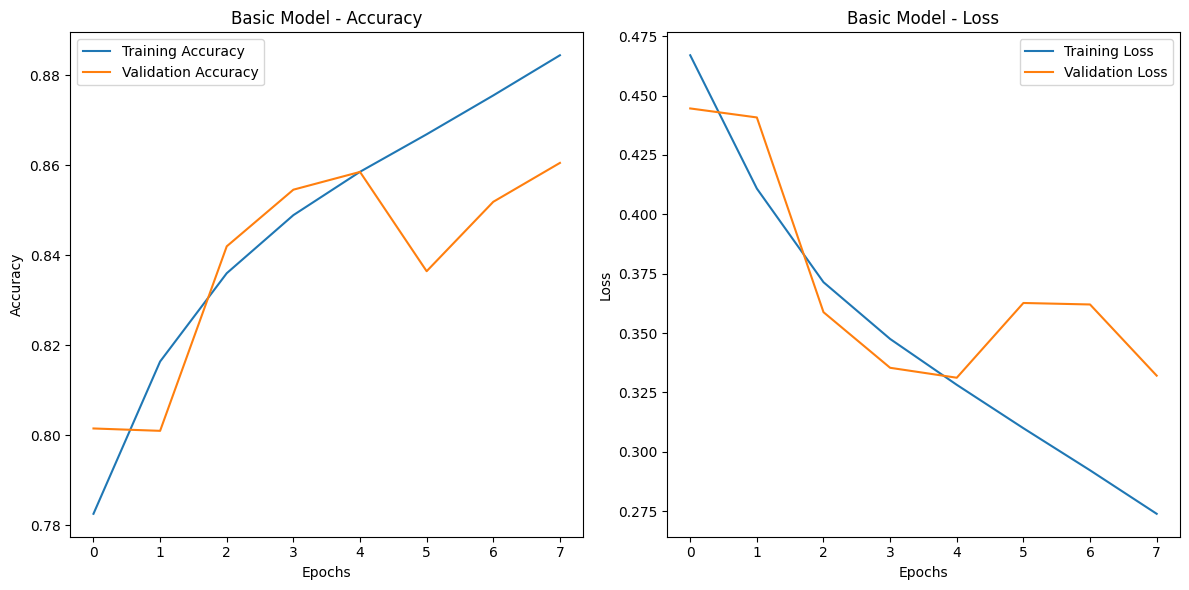

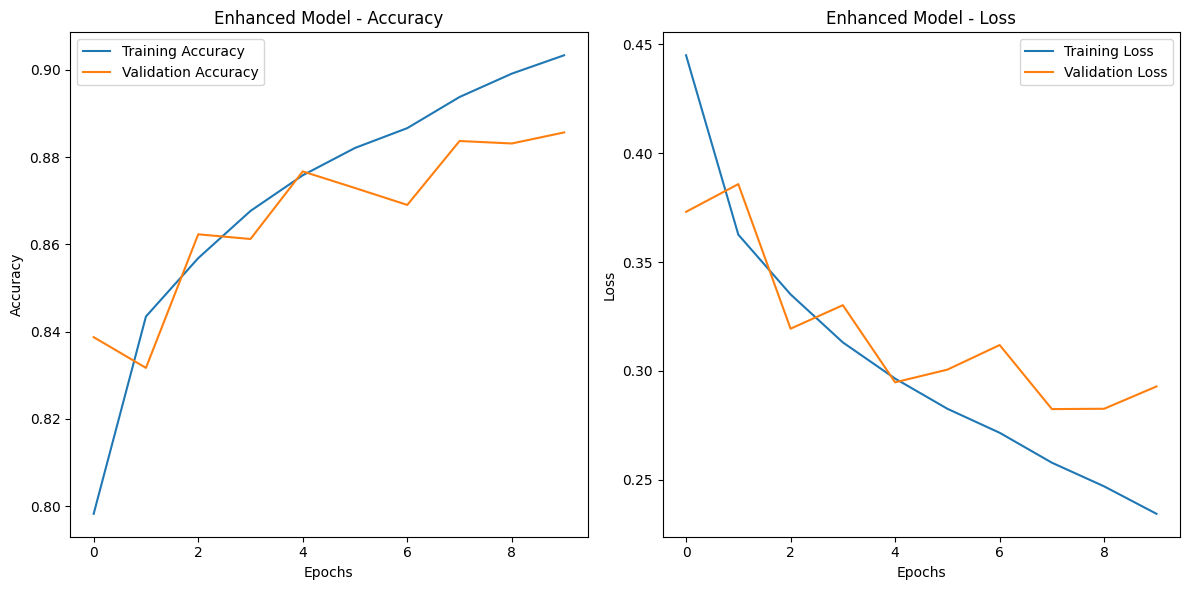

In [53]:
# Plot training and validation accuracy for Basic Model
plt.figure(figsize=(12, 6))

# Accuracy plot for Basic Model
plt.subplot(1, 2, 1)  # Subplot 1 (1 row, 2 columns, 1st plot)
plt.plot(basic_history.history['accuracy'], label='Training Accuracy')
plt.plot(basic_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Basic Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot for Basic Model
plt.subplot(1, 2, 2)  # Subplot 2 (1 row, 2 columns, 2nd plot)
plt.plot(basic_history.history['loss'], label='Training Loss')
plt.plot(basic_history.history['val_loss'], label='Validation Loss')
plt.title('Basic Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust spacing between plots
plt.show()

# Plot training and validation accuracy for Enhanced Model
plt.figure(figsize=(12, 6))

# Accuracy plot for Enhanced Model
plt.subplot(1, 2, 1)  # Subplot 1 (1 row, 2 columns, 1st plot)
plt.plot(enhanced_history.history['accuracy'], label='Training Accuracy')
plt.plot(enhanced_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Enhanced Model - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot for Enhanced Model
plt.subplot(1, 2, 2)  # Subplot 2 (1 row, 2 columns, 2nd plot)
plt.plot(enhanced_history.history['loss'], label='Training Loss')
plt.plot(enhanced_history.history['val_loss'], label='Validation Loss')
plt.title('Enhanced Model - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust spacing between plots
plt.show()

